In [1]:
# # pip install wandb
# import torch
API_KEY = "b2b0dd5d93dd202de7b95a8db071b49f0c9bfad0"
# torch.cuda.empty_cache()


In [2]:

def edit_dataframe(dataframe):
    def format_row(row):
        return f"[CLS] {row['original_text']} [SEP] The task is to rewrite this narrative to {row['rewritten_text']} using this following prompt: {row['rewrite_prompt']}"


    # Step 1: Load the CSV file into a pandas DataFrame
#     dataframe = pd.read_csv("data/8000_data.csv")[:1000]
    dataframe = dataframe.rename(columns={'prompt':'rewrite_prompt'})

    assert "original_text" in dataframe.columns and "rewritten_text" in dataframe.columns and "rewrite_prompt" in dataframe.columns
#     dataframe['intputs_text'] = f"[CLS] {dataframe['original_text']} [SEP] The task is to rewrite this narrative to {dataframe['rewritten_text']} using this following prompt: "
    dataframe['intputs_text'] = dataframe.apply(format_row, axis=1)
    # Step 2: Tokenize the Data
    # Initialize the tokenizers
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Encode the texts
    def preprocess_function(examples):
        inputs = examples["intputs_text"]
        targets = examples["rewrite_prompt"]
        model_inputs = bert_tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

        # Setup the tokenizer for targets
        with bert_tokenizer.as_target_tokenizer():
            labels = bert_tokenizer(targets, max_length=60, truncation=True, padding="max_length")

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    # Apply the tokenization to the dataset
    dataset = Dataset.from_pandas(dataframe)
    tokenized_datasets = dataset.map(preprocess_function, batched=True)
    
    return tokenized_datasets

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EncoderDecoderModel
from transformers import BertTokenizer, DataCollatorForSeq2Seq

# # Step 1: Load the CSV file into a pandas DataFrame
# dataframe = pd.read_csv("data/8000_data.csv")[:1000]
# dataframe = dataframe.rename(columns={'prompt':'rewrite_prompt'})

# assert "original_text" in dataframe.columns and "rewritten_text" in dataframe.columns and "rewrite_prompt" in dataframe.columns
# dataframe['intputs_text'] = f"[CLS] {dataframe['original_text']} [SEP] The task is to rewrite this narrative to {dataframe['rewritten_text']} using this following prompt: "

# # Step 2: Tokenize the Data
# # Initialize the tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Encode the texts
# def preprocess_function(examples):
#     inputs = examples["intputs_text"]
#     targets = examples["rewrite_prompt"]
#     model_inputs = bert_tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

#     # Setup the tokenizer for targets
#     with bert_tokenizer.as_target_tokenizer():
#         labels = bert_tokenizer(targets, max_length=128, truncation=True, padding="max_length")

#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

# # Apply the tokenization to the dataset
# dataset = Dataset.from_pandas(dataframe)
# tokenized_datasets = dataset.map(preprocess_function, batched=True)


train_df = pd.read_csv("data/8000_data.csv")[:1000]
val_df = pd.read_csv("data/8000_data.csv")[1000:1200]

train_df = edit_dataframe(train_df)
val_df = edit_dataframe(val_df)

# Step 3: Initialize the Model
model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased').to(device)
model.config.decoder_start_token_id = bert_tokenizer.cls_token_id
model.config.pad_token_id = bert_tokenizer.pad_token_id
model.config.eos_token_id = bert_tokenizer.sep_token_id

# Step 4: Set Up Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # You can change the number of epochs
    per_device_train_batch_size=4,  # Adjust based on your GPU memory
    prediction_loss_only=False,
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    log_level="critical",
)

# Step 5: Initialize the Trainer
data_collator = DataCollatorForSeq2Seq(tokenizer=bert_tokenizer, model=model)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    tokenizer=bert_tokenizer,
    data_collator=data_collator,
    eval_dataset=val_df,
)

# Step 6: Train
trainer.train()

2024-03-20 00:28:00.137436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/home/b2zhu/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/home/b2zhu/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 804962881z. Use `wandb login --relogin` to force relogin


/home/b2zhu/.local/lib/python3.9/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:636: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch,Training Loss,Validation Loss
1,No log,9.972977


TrainOutput(global_step=25, training_loss=11.972081298828124, metrics={'train_runtime': 13.7406, 'train_samples_per_second': 7.278, 'train_steps_per_second': 1.819, 'total_flos': 61345410048000.0, 'train_loss': 11.972081298828124, 'epoch': 1.0})

In [4]:
train_df[0]

{'original_text': "I get it now. You have to give to get. Where's did I put the cereal? You ca n't have life without death. Or love without hate. I think this milk is sour. Maybe it's fine. Maybe I'm fine, just the way I am.   I have to shower before I go. Maybe the only reason everything is so shit is because I expect it to be. A positive attitude might be the only thing I need. Shit, I'm going to be late.   Learn to drive, asshole! I need to relax, like in that dream, some real Zen stuff. Love and equality and all that. Fuck, I spilled my coffee. Today is going to be hell.",
 'rewrite_prompt': 'Convey the same message as this text but through the eyes of a alien planet philosophical inquiry.',
 'rewritten_text': '"The cosmic tapestry of existence unraveled before me, illuminating the interconnectedness of all phenomena. I perceive the enigmatic axiom woven through the threads of life and death, love and hate. It is an axiom inscribed in the cosmic consciousness, a testament to the du

In [5]:
predictions = trainer.predict(val_df)
print(predictions.predictions)
print(predictions.label_ids)


(array([[[ -8.148014 ,  -8.717522 ,  -8.500813 , ...,  -6.348462 ,
          -5.329439 ,  -7.491818 ],
        [ -8.164964 ,  -8.712038 ,  -8.514556 , ...,  -6.630982 ,
          -5.4416075,  -6.8154573],
        [ -4.33862  ,  -4.895731 ,  -4.7556825, ...,  -4.59076  ,
          -3.3871663,  -2.7873948],
        ...,
        [  5.276188 ,   4.743595 ,   4.815857 , ...,   4.410636 ,
           2.9372444,   5.130015 ],
        [  5.3662014,   4.81548  ,   4.897099 , ...,   4.350775 ,
           2.9771955,   4.9931083],
        [  5.430087 ,   4.9055414,   4.983341 , ...,   4.359182 ,
           3.0539412,   5.139162 ]],

       [[ -8.226884 ,  -8.978163 ,  -8.626903 , ...,  -6.1601706,
          -5.1804686,  -7.0861926],
        [ -8.428145 ,  -9.250065 ,  -8.774749 , ...,  -6.543469 ,
          -5.7763395,  -6.605445 ],
        [ -4.557111 ,  -5.186827 ,  -4.8041773, ...,  -4.643807 ,
          -3.4000382,  -3.2531343],
        ...,
        [  5.464189 ,   4.9617248,   5.182561 , ..., 

In [6]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2866 MiB |   6101 MiB | 436587 MiB | 433720 MiB |
|       from large pool |   2862 MiB |   6096 MiB | 417635 MiB | 414772 MiB |
|       from small pool |      3 MiB |    151 MiB |  18952 MiB |  18948 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   2866 MiB |   6101 MiB | 436587 MiB | 433720 MiB |
|       from large pool |   2862 MiB |   6096 MiB | 417635 MiB |

In [7]:
# results = trainer.evaluate()
# print(results)
predictions.predictions[0]

array([[[ -8.148014 ,  -8.717522 ,  -8.500813 , ...,  -6.348462 ,
          -5.329439 ,  -7.491818 ],
        [ -8.164964 ,  -8.712038 ,  -8.514556 , ...,  -6.630982 ,
          -5.4416075,  -6.8154573],
        [ -4.33862  ,  -4.895731 ,  -4.7556825, ...,  -4.59076  ,
          -3.3871663,  -2.7873948],
        ...,
        [  5.276188 ,   4.743595 ,   4.815857 , ...,   4.410636 ,
           2.9372444,   5.130015 ],
        [  5.3662014,   4.81548  ,   4.897099 , ...,   4.350775 ,
           2.9771955,   4.9931083],
        [  5.430087 ,   4.9055414,   4.983341 , ...,   4.359182 ,
           3.0539412,   5.139162 ]],

       [[ -8.226884 ,  -8.978163 ,  -8.626903 , ...,  -6.1601706,
          -5.1804686,  -7.0861926],
        [ -8.428145 ,  -9.250065 ,  -8.774749 , ...,  -6.543469 ,
          -5.7763395,  -6.605445 ],
        [ -4.557111 ,  -5.186827 ,  -4.8041773, ...,  -4.643807 ,
          -3.4000382,  -3.2531343],
        ...,
        [  5.464189 ,   4.9617248,   5.182561 , ...,  

In [17]:
logits = predictions.predictions[0]

token_ids = np.argmax(logits, axis=-1)
token_ids[0]
# decoded_texts = [bert_tokenizer.decode(ids, skip_special_tokens=True) for ids in token_ids]
# decoded_texts[0]

array([17266, 17266,  5743, 17266,  5743,  2433,  5743,  1996,  2433,
        1997,  6728,  6728,  2614, 17266,  1012,  2133,  1012,  5685,
       23166, 25292, 25292, 25292, 25292, 13657, 13657, 13657, 13657,
       13657, 13657, 13657, 13657, 13657, 13657, 13657, 13657, 13657,
       13657, 13657, 13657, 13657, 13657, 13657, 13657, 13657, 13657,
       13657, 21067, 13657, 13657, 13657, 13657, 13657, 13657, 13657,
       13657, 13657, 13657, 13657, 13657, 13657])

In [8]:
logits = predictions.predictions[0]

token_ids = np.argmax(logits, axis=-1)
decoded_texts = [bert_tokenizer.decode(ids, skip_special_tokens=True) for ids in token_ids]
decoded_texts[0]
# length_dict = {}
# df = pd.read_csv("data/8000_data.csv")
# df
# for text in df["prompt"]:
#     one_len = len(bert_tokenizer(text)["input_ids"])

# #     one_len = len(text.split(" "))
#     # Increment the count for this length in the dictionary
#     if one_len in length_dict:
#         length_dict[one_len] += 1
#     else:
#         length_dict[one_len] = 1
#     break
    # For demonstration, printing the first decoded text and breaking the loop
#     print(decoded_text)
#     break

# Print the length distribution

# print(length_dict)


{20: 332, 18: 563, 13: 699, 16: 452, 15: 540, 19: 442, 21: 371, 22: 205, 17: 473, 23: 258, 14: 696, 25: 371, 26: 235, 24: 160, 27: 124, 28: 234, 29: 131, 10: 283, 12: 332, 30: 196, 41: 41, 11: 274, 48: 1, 38: 45, 33: 106, 31: 118, 45: 1, 49: 1, 32: 102, 36: 59, 47: 19, 39: 20, 35: 17, 34: 32, 37: 20, 9: 54}


In [9]:
# print(len(length_dict))

36


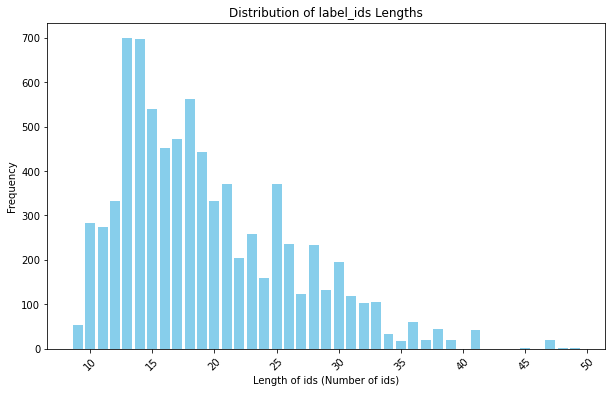

In [10]:
# import matplotlib.pyplot as plt

# # Assuming length_dict is your dictionary containing the distribution of lengths
# lengths = list(length_dict.keys())
# counts = list(length_dict.values())

# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# plt.bar(lengths, counts, color='skyblue')  # Create a bar chart
# plt.title('Distribution of label_ids Lengths')  # Add a title
# plt.xlabel('Length of ids (Number of ids)')  # Label the x-axis
# plt.ylabel('Frequency')  # Label the y-axis
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability, if needed
# plt.show() 